In [58]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from absl import logging
import warnings

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages
warnings.filterwarnings('ignore')
# Suppress the specific warning message
logging.set_verbosity(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning, message=".*HDF5 file via `model.save.*")

# Import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Input


from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Sample TensorFlow operation to verify installation
a = tf.constant([1.0, 2.0, 3.0])
b = tf.constant([4.0, 5.0, 6.0])
c = a + b
print("TensorFlow operation result:", c.numpy())


TensorFlow version: 2.16.2
TensorFlow operation result: [5. 7. 9.]


In [59]:
directory_train = './Data/Train'
directory_validation = './Data/Val'
directory_test = './Data/Prediction'

In [61]:
# Data augmentation
gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,  # Reduced rotation range
    zoom_range=0.1,     # Reduced zoom range
    shear_range=0.1,    # Reduced shear range
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)


# Data generators
train_generator = gen.flow_from_directory(
    directory=directory_train,
    color_mode="rgb",
    target_size=(331, 331),
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

validation_generator = gen.flow_from_directory(
    directory=directory_validation,
    color_mode="rgb",
    target_size=(331, 331),
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 288 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [62]:
# Create a DataFrame for the test data
#The issue arises because the flow_from_directory method expects the data to be organized into subdirectories, where each subdirectory represents a class. Since your test directory does not have this structure, you need to use a different method to load the images for evaluation.
# You can use flow_from_dataframe or manually load and preprocess the images.
test_files = [os.path.join(directory_test, fname) for fname in os.listdir(directory_test)]
test_labels = ['Normal' if 'NORMAL' in fname else 'COVID-19' for fname in os.listdir(directory_test)]  # Adjust as necessary for your classes

test_df = pd.DataFrame({
    'filename': test_files,
    'class': test_labels
})

# Data generator using flow_from_dataframe
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(331, 331),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=False # Do not shuffle test data
)


Found 23 validated image filenames belonging to 2 classes.


In [63]:
x, y = next(train_generator)
x.shape

(8, 331, 331, 3)

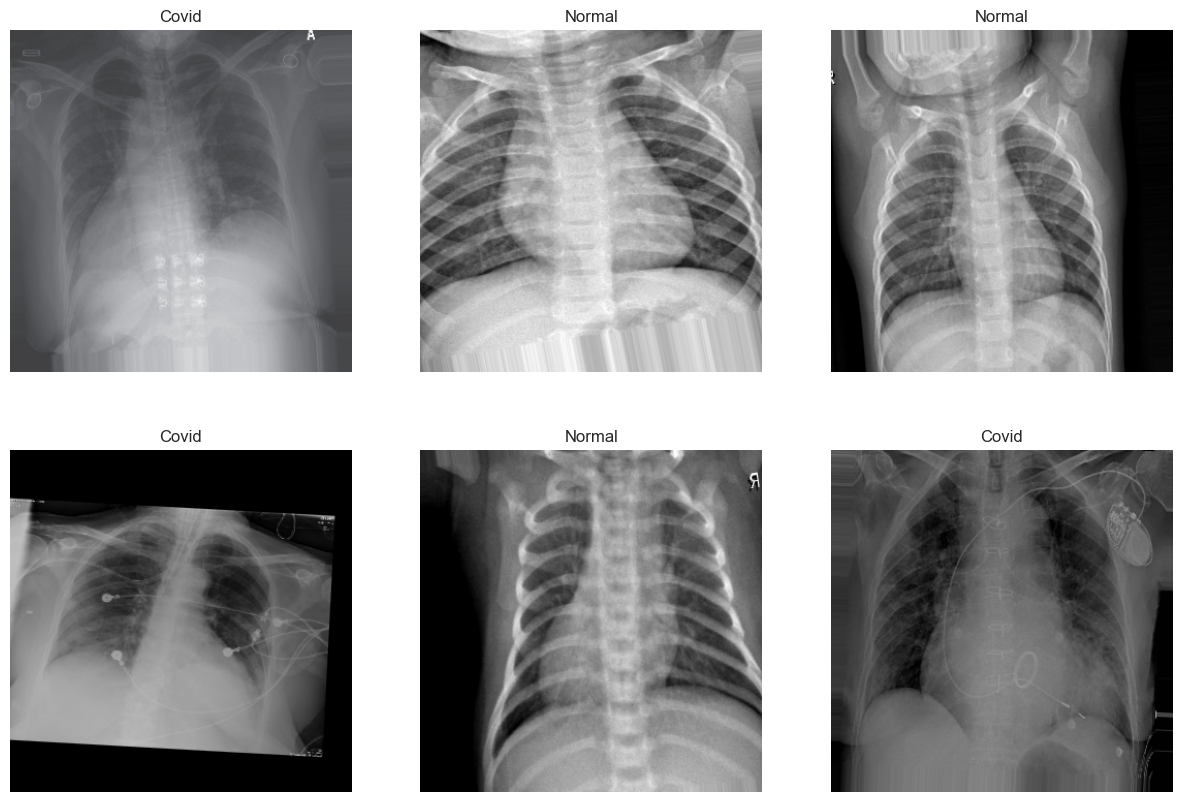

In [64]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

In [67]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import BatchNormalization
# Build the model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(331, 331, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(120, activation='softmax'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)


Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.6556 - loss: 0.6924 - val_accuracy: 0.5500 - val_loss: 0.6919
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - accuracy: 0.9085 - loss: 0.6868 - val_accuracy: 0.6833 - val_loss: 0.6851
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 183s 5s/step - accuracy: 0.8605 - loss: 0.6628 - val_accuracy: 0.7833 - val_loss: 0.6478
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.8764 - loss: 0.6047 - val_accuracy: 0.8500 - val_loss: 0.5980
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.8920 - loss: 0.5822 - val_accuracy: 0.9167 - val_loss: 0.5746
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.9197 - loss: 0.5606 - val_accuracy: 0.9167 - val_loss: 0.5568
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 215s 6s/step - accuracy: 0.8969 - loss: 0.5666 - val_accuracy: 0.9500 - val_loss: 0.5457
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 315s 9s/step - accuracy: 0.9582 - loss: 0.5398 - val_accuracy: 0.9500 - v

In [11]:
# Export our model to HDF5 file
#model.save("covid_xray_model.h5")

In [ ]:
# Load the model
#model = tf.keras.models.load_model('covid_xray_model.h5')
# Optionally, verify the model by printing its summary
# model.summary()

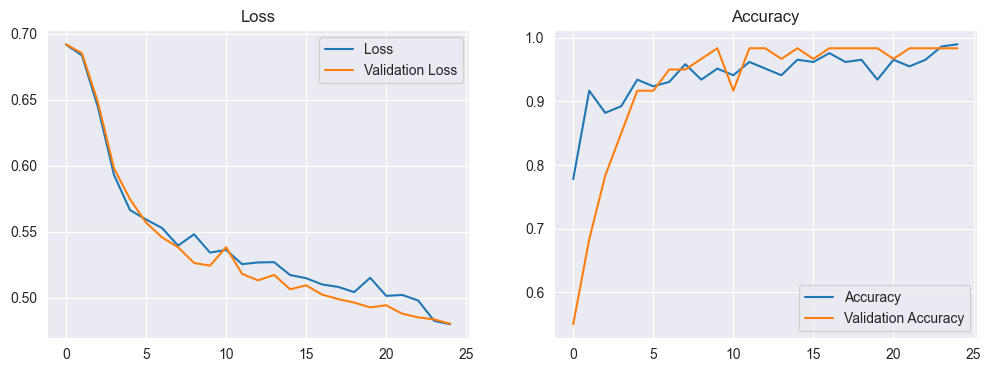

In [68]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [69]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 1.0000 - loss: 0.4715
Test Loss: 0.47143763303756714, Test Accuracy: 1.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


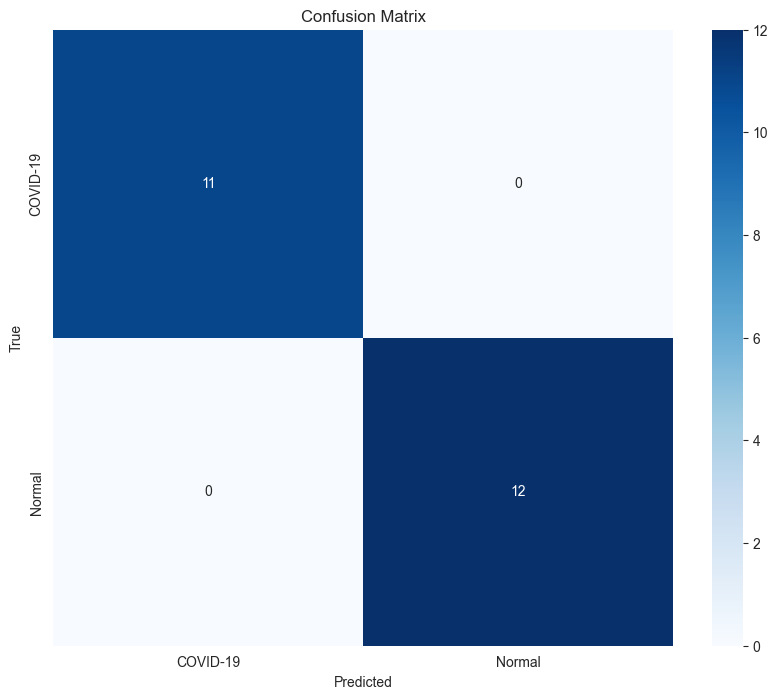

In [70]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Generate classification report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00        11
      Normal       1.00      1.00      1.00        12

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


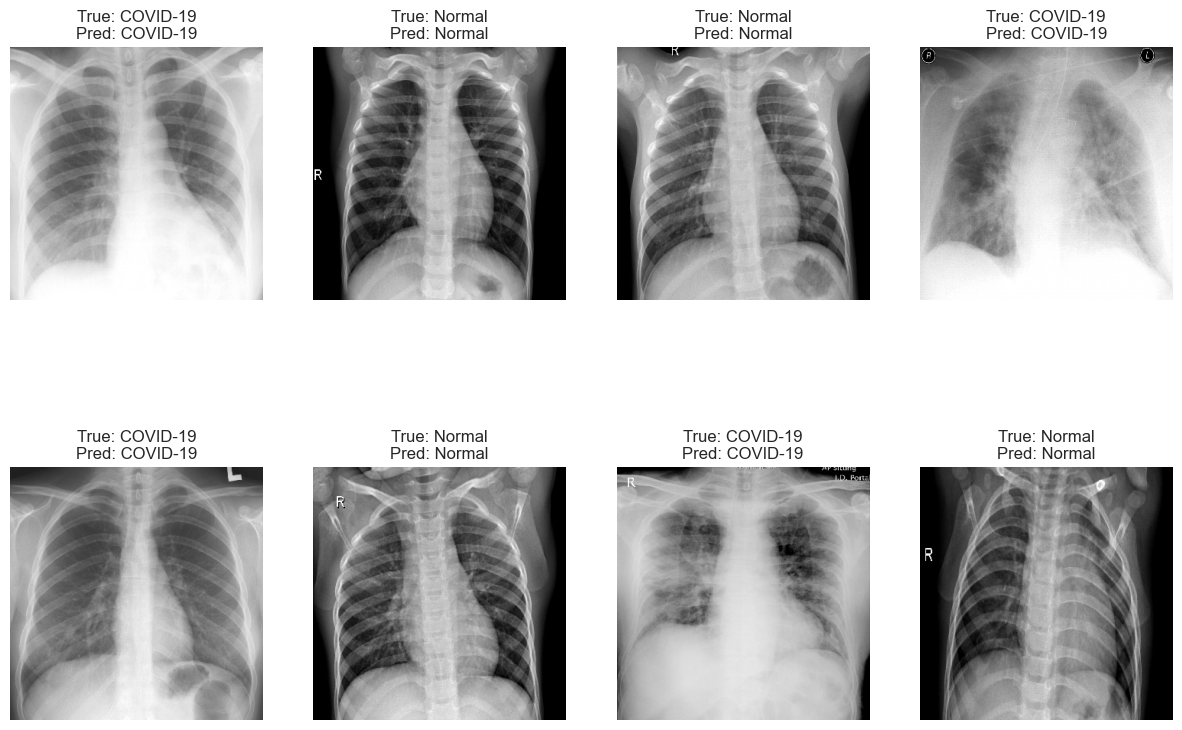

In [72]:
def plot_predicted_images(generator, model, num_images=8):
    class_names = list(generator.class_indices.keys())
    images, labels = next(generator)
    predictions = model.predict(images)
    
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        true_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[i])]
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    plt.show()

# Call the function to plot predicted images
plot_predicted_images(test_generator, model)

# Data Model Optimisation
####  Enhanced Data Augmentation - Ensure that data augmentation techniques are properly configured to improve model robustness.